In [3]:
from astropy.io import fits
from astropy.table import Table, Column, join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from matplotlib.colors import LogNorm
import astropy.units as u
from astropy.convolution import Gaussian2DKernel,Tophat2DKernel,Gaussian1DKernel
from astropy.convolution import convolve, convolve_fft
from astropy.coordinates import SkyCoord
import glob
import os
from astropy.visualization import ZScaleInterval
import matplotlib.ticker as ticker

from matplotlib.gridspec import GridSpec
from astropy.visualization import (MinMaxInterval, SqrtStretch, ImageNormalize)
from astropy.table import Table
import numpy as np
from scipy.optimize import curve_fit
import re
from matplotlib.patches import Circle
import msaexp
import msaexp.spectrum
print(f'msaexp version: {msaexp.__version__}')
from scipy.integrate import simps
from scipy.interpolate import interp1d
# import sigma_clipping
from astropy.stats import sigma_clip,sigma_clipped_stats


plt.style.use('../paper.mplstyle')

BASE_URL = 'https://s3.amazonaws.com/msaexp-nirspec/extractions/'
PATH_TO_FILE = BASE_URL + '{root}/{file}'
# define the absolute path of the current working directory
current_direc = os.getcwd() 


def draw_aper(ax, centerx, centery,phot_radius):
    c = Circle((centerx, centery ), float(phot_radius)/2, edgecolor='red', facecolor='None')
    ax.add_patch(c)
    return

# Define the linear model for fitting
def magnitude_model(log_lambda, beta, c):
    return -2.5 * (beta + 2) * log_lambda + c

def fit_beta(wavelengths, magnitudes, mag_errors):
    """
    Calculate the spectral slope (beta) using linear least-squares fitting.
    Parameters:
    wavelengths (array): Effective wavelengths of the filters.
    magnitudes (array): Observed magnitudes in the filters.
    mag_errors (array): Errors in the observed magnitudes.
    
    Returns:
    beta (float): Best-fit spectral slope.
    beta_err (float): Error in the spectral slope.
    """
    # Convert wavelengths to log scale
    log_wavelengths = np.log10(wavelengths)

    # Perform the fit
    popt, pcov = curve_fit(
        magnitude_model,
        log_wavelengths,
        magnitudes,
        # sigma=mag_errors,
        absolute_sigma=True
    )

    beta, c = popt
    beta_err = np.sqrt(pcov[0, 0])  # Error in beta
    return beta, beta_err, c

import numpy as np

def nJy_to_ABmag(flux, flux_error):
    """
    将流量 (nJy) 转换为 AB 星等，并计算误差。
    
    参数:
        flux (float or np.ndarray): 流量值，单位为 nJy。
        flux_error (float or np.ndarray): 流量的误差，单位为 nJy。
    
    返回:
        tuple: 星等 (magnitude) 和星等误差 (magnitude_error)。
    """
    # 防止非正流量导致对数计算报错
    flux = np.array(flux)
    flux_error = np.array(flux_error)
    
    # 仅对 flux > 0 计算
    valid = flux > 0
    magnitude = np.full_like(flux, np.nan, dtype=np.float64)  # 默认 NaN
    magnitude_error = np.full_like(flux, np.nan, dtype=np.float64)  # 默认 NaN
    
    if np.any(valid):
        magnitude[valid] = -2.5 * np.log10(flux[valid]) + 23.9
        magnitude_error[valid] = 2.5 / np.log(10) * (flux_error[valid] / flux[valid])
    
    return magnitude, magnitude_error

def match_sources_within_radius(catalog, target_id, radius=1):
    """
    Find sources within a given radius (in arcseconds) of a target source in the catalog.
    
    Parameters:
    - catalog (astropy.table.Table or pandas.DataFrame): The catalog containing source data.
    - target_id (int): The ID of the target source to match against.
    - radius (float): The radius within which to find matches (default: 1 arcsecond).
    
    Returns:
    - astropy.table.Table or pandas.DataFrame: Subset of the catalog with matching sources.
    """
    # Ensure the catalog is in the correct format
    if isinstance(catalog, pd.DataFrame):
        catalog = catalog.copy()
        ra_col, dec_col = catalog["RA"].values, catalog["DEC"].values
    else:  # Assuming astropy Table
        ra_col, dec_col = catalog["RA"], catalog["DEC"]

    # Get target source RA and DEC
    target_row = catalog[catalog["ID"] == target_id]
    if len(target_row) == 0:
        raise ValueError(f"Target ID {target_id} not found in the catalog.")
    target_ra = target_row["RA"][0]
    target_dec = target_row["DEC"][0]

    # Convert catalog to SkyCoord objects
    target_coord = SkyCoord(ra=target_ra * u.deg, dec=target_dec * u.deg)
    source_coords = SkyCoord(ra=ra_col * u.deg, dec=dec_col * u.deg)

    # Find sources within the radius
    sep = target_coord.separation(source_coords)
    matched_indices = sep.arcsecond <= radius

    # Return the matched sources
    return matched_indices

def binspec(wavelength, smoothspec, error, bin_width=5):

    # 创建新的波长数组，定义 bin 的中心点
    binned_wavelength = np.arange(wavelength[0], wavelength[-1], bin_width)

    # 初始化 binned 光谱和误差
    binned_spec = []
    binned_error = []

    # 对每个 bin 进行平均
    for i in range(len(binned_wavelength) - 1):
        # 找到属于当前 bin 的数据点
        idx = (wavelength >= binned_wavelength[i]) & (wavelength < binned_wavelength[i + 1])
        if np.any(idx):  # 确保有点落入 bin
            mean_value = np.mean(smoothspec[idx])  # 平均光谱值
            # 误差使用平方和的开方计算
            mean_error = np.sqrt(np.sum(error[idx]**2) / np.sum(idx))
            
            binned_spec.append(mean_value)
            binned_error.append(mean_error)
        else:
            binned_spec.append(np.nan)  # 如果 bin 没有数据，用 NaN 填充
            binned_error.append(np.nan)

    # 转换为 numpy 数组
    binned_spec = np.array(binned_spec)
    binned_error = np.array(binned_error)

    # 去除 NaN 的 bin（可选）
    valid_idx = ~np.isnan(binned_spec)
    binned_wavelength = binned_wavelength[:-1][valid_idx]
    binned_spec = binned_spec[valid_idx]
    binned_error = binned_error[valid_idx]

    return binned_wavelength, binned_spec, binned_error

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

Duplicate key in file '../paper.mplstyle', line 23 ('axes.linewidth : 1.5')


msaexp version: 0.9.2


In [4]:

def draw_aper(ax, centerx, centery,phot_radius):
    c = Circle((centerx, centery ), float(phot_radius)/2, edgecolor='red', facecolor='None')
    ax.add_patch(c)
    return

# Define the linear model for fitting
def magnitude_model(log_lambda, beta, c):
    return -2.5 * (beta + 2) * log_lambda + c

def fit_beta(wavelengths, magnitudes, mag_errors):
    """
    Calculate the spectral slope (beta) using linear least-squares fitting.
    Parameters:
    wavelengths (array): Effective wavelengths of the filters.
    magnitudes (array): Observed magnitudes in the filters.
    mag_errors (array): Errors in the observed magnitudes.
    
    Returns:
    beta (float): Best-fit spectral slope.
    beta_err (float): Error in the spectral slope.
    """
    # Convert wavelengths to log scale
    log_wavelengths = np.log10(wavelengths)

    # Perform the fit
    popt, pcov = curve_fit(
        magnitude_model,
        log_wavelengths,
        magnitudes,
        # sigma=mag_errors,
        absolute_sigma=True
    )

    beta, c = popt
    beta_err = np.sqrt(pcov[0, 0])  # Error in beta
    return beta, beta_err, c

import numpy as np

def nJy_to_ABmag(flux, flux_error):
    """
    将流量 (nJy) 转换为 AB 星等，并计算误差。
    
    参数:
        flux (float or np.ndarray): 流量值，单位为 nJy。
        flux_error (float or np.ndarray): 流量的误差，单位为 nJy。
    
    返回:
        tuple: 星等 (magnitude) 和星等误差 (magnitude_error)。
    """
    # 防止非正流量导致对数计算报错
    flux = np.array(flux)
    flux_error = np.array(flux_error)
    
    # 仅对 flux > 0 计算
    valid = flux > 0
    magnitude = np.full_like(flux, np.nan, dtype=np.float64)  # 默认 NaN
    magnitude_error = np.full_like(flux, np.nan, dtype=np.float64)  # 默认 NaN
    
    if np.any(valid):
        magnitude[valid] = -2.5 * np.log10(flux[valid]) + 23.9
        magnitude_error[valid] = 2.5 / np.log(10) * (flux_error[valid] / flux[valid])
    
    return magnitude, magnitude_error

def match_sources_within_radius(catalog, target_id, radius=1):
    """
    Find sources within a given radius (in arcseconds) of a target source in the catalog.
    
    Parameters:
    - catalog (astropy.table.Table or pandas.DataFrame): The catalog containing source data.
    - target_id (int): The ID of the target source to match against.
    - radius (float): The radius within which to find matches (default: 1 arcsecond).
    
    Returns:
    - astropy.table.Table or pandas.DataFrame: Subset of the catalog with matching sources.
    """
    # Ensure the catalog is in the correct format
    if isinstance(catalog, pd.DataFrame):
        catalog = catalog.copy()
        ra_col, dec_col = catalog["RA"].values, catalog["DEC"].values
    else:  # Assuming astropy Table
        ra_col, dec_col = catalog["RA"], catalog["DEC"]

    # Get target source RA and DEC
    target_row = catalog[catalog["ID"] == target_id]
    if len(target_row) == 0:
        raise ValueError(f"Target ID {target_id} not found in the catalog.")
    target_ra = target_row["RA"][0]
    target_dec = target_row["DEC"][0]

    # Convert catalog to SkyCoord objects
    target_coord = SkyCoord(ra=target_ra * u.deg, dec=target_dec * u.deg)
    source_coords = SkyCoord(ra=ra_col * u.deg, dec=dec_col * u.deg)

    # Find sources within the radius
    sep = target_coord.separation(source_coords)
    matched_indices = sep.arcsecond <= radius

    # Return the matched sources
    return matched_indices

def plot_SED_src(large_subplot, df, name, symbol, color, factor=1.0):
    global filters_wavelength, NIRCAM_filter, kron_cols, kron_err_cols
    wavelengths = [filters_wavelength[band.upper()] for band in NIRCAM_filter]
    wavelengths = np.array(wavelengths)
    fluxes = df[kron_cols].values.flatten()
    flux_errors = df[kron_err_cols].values.flatten()
    mask = (fluxes > 0) & (flux_errors > 0)
    fluxes = fluxes[mask]
    flux_errors = flux_errors[mask]
    wavelengths = wavelengths[mask]
    goodfilters = NIRCAM_filter[mask]
    # NIRCAM_flux = NIRCAM_MAG
    # NIRCAM_fluxerr = NIRCAM_MAGerr
    # NIRCAM_flux = abmag_to_nJy(NIRCAM_MAG)#/1e3
    # NIRCAM_fluxerr = abmag_to_nJyerr(NIRCAM_MAG, NIRCAM_MAGerr)#/1e3
    # NIRCAM_wave = np.array(NIRCAMwave)[mask]
    # NIRCAM_flux = NIRCAM_flux[mask]
    # NIRCAM_fluxerr = NIRCAM_fluxerr[mask]
    large_subplot.errorbar(wavelengths, fluxes*factor, yerr=flux_errors, 
                           color=color, ecolor=color, fmt=symbol, markersize=20,
                           elinewidth=0.5, capsize=2, capthick=1, markerfacecolor='none', label = name)
    # large_subplot.scatter(restwave*(1+z), fnu/np.mean(fnu)*np.mean(NIRCAM_flux)*2.4, s=100, c='red', marker='x', label='Akin24 mean SED')
    large_subplot.tick_params(axis='both', which='major', labelsize=20, direction='in')
    large_subplot.set_xlabel(r'Observed Wavelength $(\mu \rm m)$', fontsize=20)
    # large_subplot.set_ylabel('MAG', fontsize=20)
    large_subplot.set_ylabel('Flux (nJy)', fontsize=20)
    large_subplot.set_yscale('log')
    large_subplot.set_xscale('log')
    large_subplot.set_xticks([1,1.5,2,3,4,5])
    large_subplot.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    large_subplot.minorticks_off()
    
    return wavelengths,fluxes,flux_errors,goodfilters

def read_results_from_txt(filename):
    """
    Read flux, EW, FWHM results with errors, Gaussian parameters, and Chi-squared values from a text file.

    Parameters:
    - filename: Path to the input text file.
    
    Returns:
    - A dictionary containing all the extracted parameters, including Gaussian parameters and their errors.
    """
    results = {}

    with open(filename, 'r') as f:
        lines = f.readlines()

    # Extract source ID
    results['source_id'] = lines[0].split(":")[1].strip()

    # Find the number of Gaussian components
    for line in lines:
        if line.startswith("Number of Gaussian Components"):
            results['num_gaussians'] = int(line.split(":")[1].strip())
            break
    
    # Extract Gaussian components parameters and errors
    gaussians = []
    current_gaussian = None
    for line in lines:
        if line.startswith("Gaussian"):
            if current_gaussian is not None:
                gaussians.append(current_gaussian)
            current_gaussian = {}
        if line.startswith("  Amplitude"):
            current_gaussian['Amplitude'] = float(line.split('=')[1].split('±')[0].strip())
            current_gaussian['Amplitude_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("  Mean (Velocity)"):
            current_gaussian['Mean'] = float(line.split('=')[1].split('±')[0].strip())
            current_gaussian['Mean_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("  Stddev (Width)"):
            current_gaussian['Stddev'] = float(line.split('=')[1].split('±')[0].strip())
            current_gaussian['Stddev_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("-" * 40):  # End of a Gaussian block
            if current_gaussian is not None:
                gaussians.append(current_gaussian)
                current_gaussian = None

    # remove empty gaussians
    gaussians = [g for g in gaussians if g]
    results['gaussians'] = gaussians
    

    # Extract component results (Flux, EW, FWHM)
    components = []
    current_component = None
    for line in lines:
        if line.startswith("Gaussian"):
            if current_component is not None:
                components.append(current_component)
            current_component = {}
        if line.startswith("  Flux"):
            current_component['Flux'] = float(line.split('=')[1].split('±')[0].strip())
            current_component['Flux_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("  EW"):
            current_component['EW'] = float(line.split('=')[1].split('±')[0].strip())
            current_component['EW_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("  FWHM"):
            current_component['FWHM'] = float(line.split('=')[1].split('±')[0].strip())
            current_component['FWHM_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("  intrinsic"):
            current_component['intrinsic_FWHM'] = float(line.split('=')[1].split('±')[0].strip())
            current_component['intrinsic_FWHM_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("  Luminosity"): 
            current_component['Luminosity'] = float(line.split('=')[1].split('±')[0].strip())
            current_component['Luminosity_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("-" * 40):  # End of a component block
            if current_component is not None:
                components.append(current_component)
                current_component = None

    # remove empty components
    components = [c for c in components if c]
    results['components'] = components

    # Extract Chi-squared and Reduced Chi-squared values
    for line in lines:
        if line.startswith("Chi-squared"):
            results['chi2'] = float(line.split(":")[1].strip())
        elif line.startswith("Reduced Chi-squared"):
            results['reduced_chi2'] = float(line.split(":")[1].strip())
        elif line.startswith("BIC"):
            results['BIC'] = float(line.split(":")[1].strip())
        elif line.startswith("AIC"):
            results['AIC'] = float(line.split(":")[1].strip())

    return results

In [5]:
def read_filter_data(filename):
    data = np.loadtxt(filename, skiprows=1)
    wavelength = data[:, 0]
    throughput = data[:, 1]
    return wavelength, throughput

def calculate_photflux(spec_wavelength, spec_flux ,band , redshift = 0):
    # 定义波段
    # fluxes = {}
    spec_wavelength = spec_wavelength * (1 + redshift)
    spec_flux = spec_flux / (1 + redshift)

    
    # 读取滤光片透过率
    file = '../nircam_throughputs/mean_throughputs/' + band.upper() + '_throughput.txt'
    wavelength, throughput = read_filter_data(file)
    # 对透过率进行插值，使其与 spec_wavelength 匹配
    wavelength = wavelength/1e4
    throughput_interpolated = np.interp(spec_wavelength, wavelength, throughput, left=0, right=0)
    # print(throughput)
    # 计算流量（积分）
    flux = simps(spec_flux * throughput_interpolated, spec_wavelength)

    return flux

def mark_emission_lines(ax,z):
    lines = {
    '[OII]': 0.3727,      # [OII] 双峰 (合并值)
    'Hγ': 0.4340,         # Hγ
    '[OIII]': 0.5007,     # [OIII]
    'Hβ': 0.4861,         # Hβ
    'Hα': 0.6563,         # Hα
    'Paα': 1.8756,        # Paschen-alpha (Paα)

}
    for line, rest_wave in lines.items():
        # for z in [5.5, 7.5]:  # 以两个红移值为例
        obs_wave = rest_wave * (1 + z)
        if obs_wave < 0.7 or obs_wave > 5.0:
            continue
        ax.axvline(obs_wave, linestyle='--', color='grey')
        ax.text(obs_wave, 1, f'{line}', rotation=90, verticalalignment='bottom',fontsize=16)



In [ ]:
all_LRD_SED = Table.read('../catalogs/all_lrd_SED.fits')
rmvarimask = [i not in [7,37,78,160,164,225,276,490] for i in all_LRD_SED['index']]
all_LRD_SED = all_LRD_SED[rmvarimask]
allsrcSED = Table.read('../catalogs/all_field_final_cat.fits')

allsrcF444W = allsrcSED['MAG_F444W']
allsrcF150W = allsrcSED['MAG_F150W']
allsrcF277W = allsrcSED['MAG_F277W']
allsrcF356W = allsrcSED['MAG_F356W']


In [7]:
jade_gal_cat = Table.read('../catalog/jades_galaxies_sfr_withspecphot_DJA.csv')
jadegalid = np.array([ 7301,  7302,  7304,  7308,  7309,  7310,  7311,  7313,  7314,
        7318,  7319,  7320,  7327,  7328,  7329,  7330,  7334,  7335,
        7338,  7339,  7341,  7342,  7345,  7362,  7367,  7371,  7591,
        7600,  7605,  7607,  7613,  7617,  7618,  7619,  7621,  7627,
        7628,  7629,  7631,  7632,  7633,  7634,  7635,  7636, 21763,
       21773, 21837])
jadegalmask = [i in jadegalid for i in jade_gal_cat['uid']]
jade_gal_cat = jade_gal_cat[jadegalmask]
jadez = jade_gal_cat['Redshift']
jadezF444mag = nJy_to_ABmag(jade_gal_cat['f_f444w'], jade_gal_cat['e_f444w'])[0]
jadezF150mag = nJy_to_ABmag(jade_gal_cat['f_f150w'], jade_gal_cat['e_f150w'])[0]

Naka23galaxy_sfr = Table.read('../catalog/Nakajima23_galaxies_phot_DJA.csv')
Naka23galaxy_id = Naka23galaxy_sfr['uid']
Naka23galaxy_mask = [i in Naka23galaxy_id for i in jade_gal_cat['uid']]
Naka23z = Naka23galaxy_sfr['z']
Naka23zF444mag = nJy_to_ABmag(Naka23galaxy_sfr['f_f444w'], Naka23galaxy_sfr['e_f444w'])[0]
Naka23zF150mag = nJy_to_ABmag(Naka23galaxy_sfr['f_f150w'], Naka23galaxy_sfr['e_f150w'])[0]

In [8]:
len(Naka23zF444mag )

107

In [11]:
all_nirspec_beta_catalog = Table.read('../catalog/all_nirspechighz_LRD_z2.ecsv')
all_nirspec_beta_catalog = all_nirspec_beta_catalog[all_nirspec_beta_catalog['compact']]
F444Wmask =  all_nirspec_beta_catalog['F444_mag']
F150Wmask =  all_nirspec_beta_catalog['F150_mag']
F356Wmask =  all_nirspec_beta_catalog['F356_mag']
F277Wmask =  all_nirspec_beta_catalog['F277_mag']
zmask = all_nirspec_beta_catalog['z']

# narrowuidlist = [22015, 16321, 12329, 9656, 19937, 15500, 8219, 15504]
narrowuidlist = [8219,12329,16321,20547,22015]
mask = [i in narrowuidlist for i in  all_nirspec_beta_catalog['uid']]





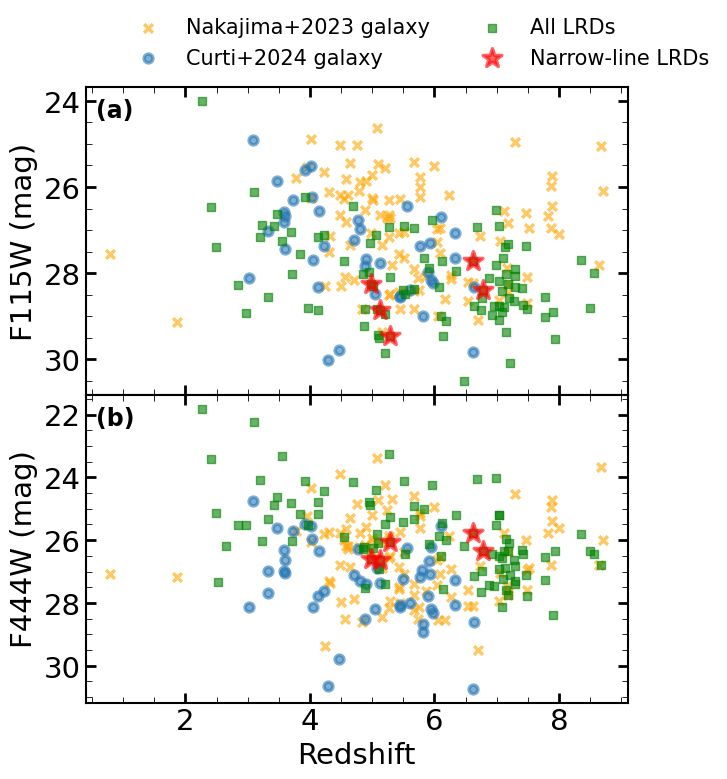

In [12]:
# mask = (all_LRD_SED['max_SN_vari'] > 3)#*(np.abs(all_LRD_SED['max_mag_vari'])>0.4)

fig, (ax2, ax1) = plt.subplots(2, 1, figsize=(7, 8), sharex=True,
                               gridspec_kw={'hspace': 0})  # hspace 控制子图垂直间距

# 可选：进一步压紧 layout，移除多余边距
plt.subplots_adjust(hspace=0)  # 再保险压紧一下

# 设置 ax2 不显示 x 轴标签（只在 ax1 显示）
ax2.tick_params(labelbottom=False)

# mmask = (allsrcF444W < 30)*(allsrcF444W > 22)
# BLmask = all_LRD_SED['isBL'] > 0
# xmin, xmax = allsrcF444W[mmask].min(), allsrcF444W[mmask].max()
# ymin, ymax = (allsrcF150W[mmask] - allsrcF444W[mmask]).min(), (allsrcF150W[mmask] - allsrcF444W[mmask]).max()
# ymin, ymax = -4.4853796157654, 6.99168253262283
# # 绘制hexbin图，使用extent参数来控制网格分布

# hb = ax1.hexbin(allsrcF444W[mmask], allsrcF150W[mmask] - allsrcF444W[mmask], extent=(xmin, xmax, ymin, ymax),
#                 gridsize=100, cmap='Greys', mincnt=100, bins='log',alpha=0.5, edgecolors=None)

# ax1.scatter(F444Wmask, (F150Wmask- F444Wmask), c='#2878B5', s=25, alpha=0.8, marker='x', edgecolors='none', label='All LRDs')
# ax1.scatter(F444Wmask[mask], (F150Wmask- F444Wmask)[mask], facecolors='red', edgecolor='red', s=200, marker='*', linewidths= 2.5, alpha = 0.5, label=r'Narrow-line LRDs')

ax1.scatter(Naka23z, Naka23zF444mag, c='orange', linewidths= 2.5, alpha = 0.6, label=r'Nakajima+2023 galaxy', marker='x', s = 40)
ax1.scatter(jadez, jadezF444mag, s=40,  linewidths= 2.5, c='#2878B5', alpha = 0.6, label=r'Curti+2024 galaxy')
ax1.scatter(zmask, F444Wmask, s=40, alpha=0.6, marker='s', c='green', label='All LRDs')
ax1.scatter(zmask[mask], F444Wmask[mask], facecolors='red', edgecolor='red', s=200, marker='*', linewidths= 2.5, alpha = 0.6, label=r'Narrow-line LRDs')
#plot density of all sources
# Add a colorbar for the density plot
# cb = fig.colorbar(hb, ax=ax1)
# cb.set_label('Source Density')
# ax3.scatter(np.log10(catalog_jadesgal['Ha_Luminosity']), np.log10(catalog_jadesgal['OIII_Luminosity']),  c='#2878B5', label='Curti+2024 galaxy', alpha=0.8)
# ax3.scatter(np.log10(catalog_naka23gal['Ha_Luminosity']), np.log10(catalog_naka23gal['OIII_Luminosity']),  c='orange', label='Nakajima+2023 galaxy', marker='x', s = 100)
# ax3.scatter(np.log10(catalog_lrd['Ha_Luminosity_narrow'][~mask]), np.log10(catalog_lrd['OIII_Luminosity'][~mask]), c='green', label='BL LRD Narrow component', marker='s', s=80, alpha=0.6)
# ax3.scatter(np.log10(catalog_lrd['Ha_Luminosity_narrow_Ha1'][mask]),np.log10(catalog_lrd['OIII_Luminosity'][mask]), c='red', label='Narrow-line LRD', s=500, marker='*')

ax1.set_xlabel('Redshift')
ax1.set_ylabel(r'F444W (mag)')
ax1.invert_yaxis()

ax2.scatter(Naka23z, Naka23zF150mag, c='orange', linewidths= 2.5, alpha = 0.6, label=r'Nakajima+2023 galaxy', marker='x', s = 40)
ax2.scatter(jadez, jadezF150mag, s=40,  linewidths= 2.5, c='#2878B5', alpha = 0.6, label=r'Curti+2024 galaxy')
ax2.scatter(zmask, F150Wmask, s=40, alpha=0.6, marker='s', c='green', label='All LRDs')
ax2.scatter(zmask[mask], F150Wmask[mask], facecolors='red', edgecolor='red', s=200, marker='*', linewidths= 2.5, alpha = 0.6, label=r'Narrow-line LRDs')
ax2.set_ylabel(r'F115W (mag)')
ax2.legend( fontsize=15, ncol = 2, bbox_to_anchor=(0.043, 1.0),  frameon=False)
ax2.invert_yaxis()
# ax1.set_xlim(30,21.5)
# ax1.set_ylim(-1, 5)
ax1.text(0.02, 0.9, '(b)', transform=ax1.transAxes, fontsize=17, weight='bold')
ax2.text(0.02, 0.9, '(a)', transform=ax2.transAxes, fontsize=17, weight='bold')

plt.savefig('../Figure/z_mag.pdf', dpi=300, bbox_inches='tight')

In [13]:
all_nirspec_beta_catalog[mask]

jname,ndup,uid,ra,dec,file,root,srcid,nGr,Grating,grade,zfit,z,comment,References,nRef,sn50,wmin,wmax,Lya,Ha,OIII,L_Ha,L_OIII,HST,NIRCam,slit,FITS,Fnu,Flam,ID_1,RA_1,DEC_1,X,Y,isoarea_SE,class_starSE,flags_SE,r50_SE,f_autoSE,e_autoSE,a_f001w,ell_f001w,theta_f001w,rKron_f001w,f_f435w,f_f606w,f_f775w,f_f814w,f_f105w,f_f125w,f_f140w,f_f160w,f_f090w,f_f115w,f_f150w,f_f200w,f_f277w,f_f356w,f_f410m,f_f444w,e_f435w,e_f606w,e_f775w,e_f814w,e_f105w,e_f125w,e_f140w,e_f160w,e_f090w,e_f115w,e_f150w,e_f200w,e_f277w,e_f356w,e_f410m,e_f444w,apopt,flag_1,ID_2,RA_2,DEC_2,zspec,zphot,EAzY_eazy_v13,EAzY_Larson,EAzY_LarsonLyaRed,flag_2,Separation_2,GroupID,GroupSize,Separation,beta_UV,beta_opt,beta_277356,beta_277410,F115_mag,F150_mag,F200_mag,F277_mag,F356_mag,F410_mag,F444_mag,method,compact
str20,int64,int64,float64,float64,str55,str22,int64,int64,str29,int64,float64,float64,str69,str48,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,str17,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,bool
j142018.78p525654.59,2,8219,215.078259,52.948497,rubies-egs51-nod-v3_prism-clear_4233_927271.spec.fits,rubies-egs51-nod-v3,927271,1,G395M,3,6.7858,6.785,Redshift matches rubies-egs51-v3_g395m-f290lp_4233_927271 z=6.7840,DKo24 z=6.790,1,1.97,0.6,5.29,-2.8,18.0,--,42.42,42.55,--,--,--,FITS zfit spl,--,--,26781,215.078252,52.948508,7813.925,5102.086,226.0,0.98,0.0,2.928,0.08491,0.00216,2.917578,0.031437,57.830051,23.340628,0.0,-0.00194,0.0,-0.00542,0.0198,0.01781,0.0,0.01326,0.0,0.01899,0.01604,0.02118,0.02733,0.07984,0.11865,0.10467,-99.0,0.0034,-99.0,0.00396,0.00715,0.00803,-99.0,0.00778,-99.0,0.00189,0.00264,0.00224,0.00177,0.00146,0.00333,0.00264,0.28,13,26781,215.078252,52.948508,6.785,6.785,6.785,6.785,6.785,13,0.0,2927,4,0.04241118285678234,-1.6434597456993238,0.2037635015098893,0.14643580101750892,0.12676480700124712,28.203687588157454,28.38698909012964,28.08518511057133,27.808400920768346,26.64444867930171,26.214330643616606,26.350444439580563,Both,True
j141911.41p524907.49,2,12329,214.797537,52.818746,rubies-egs53-nod-v3_prism-clear_4233_53254.spec.fits,rubies-egs53-nod-v3,53254,1,G395M,3,6.6207,6.621,Redshift matches rubies-egs53-v3_g395m-f290lp_4233_53254 z=6.6197,DKo24 z=6.620,1,1.55,0.6,5.29,--,21.4,--,42.54,42.41,--,--,--,FITS zfit spl,--,--,76503,214.797529,52.818758,32844.996,10495.707,316.0,0.99,0.0,4.12,0.12955,0.00364,3.925027,0.202538,-5.039738,31.400213,0.0,-0.00026,0.0,0.0031,0.0,0.01282,0.0,0.02814,0.0,0.02868,0.02949,0.02987,0.05075,0.11926,0.12402,0.1792,-99.0,0.00471,-99.0,0.0052,-99.0,0.01143,-99.0,0.00893,-99.0,0.00305,0.00366,0.00316,0.00278,0.00234,0.00398,0.00458,0.33,114,76503,214.797529,52.818758,6.621,6.621,6.621,6.621,6.621,114,0.0,3246,3,0.04657437208066234,-1.0044575330998404,0.3527368251879891,-0.729983077579366,0.27860461700217737,27.756052132510593,27.725813068620504,27.711911943489678,27.13640988353687,26.208762987475698,26.166270682472668,25.76665498668473,Both,True
j021717.79m051510.04,2,16321,34.324122,-5.252789,rubies-uds43-nod-v3_prism-clear_4233_40800.spec.fits,rubies-uds43-nod-v3,40800,1,G395M,3,4.9871,4.9864,Redshift matches rubies-uds43-v3_g395m-f290lp_4233_40800 z=4.9831,DKo24 z=N/A,1,1.29,0.6,5.29,3.2,11.5,--,41.7,41.4,--,--,--,FITS zfit spl,--,--,37072,34.3241,-5.252775,26257.211,9782.682,110.0,0.98,0.0,3.021,0.04909,0.00241,2.522432,0.112413,-52.075249,20.179457,-0.00409,0.00122,0.0,0.00443,0.0,-0.00843,-0.00166,-0.00625,0.00379,0.0038

In [15]:
import numpy as np
import pandas as pd

def extract_fit_results(txt_save_path, source_id, model):
    """读取指定模型的拟合结果。"""
    results = read_results_from_txt(txt_save_path + source_id + '_' + model + '.txt')
    if len(results) < 5:
        return None
    return results

catalog = []
grating_info = {}  # 存储光谱 grating 信息
txt_save_path = '../narrow_Ha_result_lsf_z2/'
Ha_files = glob.glob(txt_save_path + '*Ha-2-Gaussian.txt')
Ha_files.sort()
all_nirspec_beta_catalog = Table.read('../catalog/all_nirspec_beta_withclassify_z2.ecsv')
for file in Ha_files:
    source_id = file.split('/')[-1].split('_')[0] + '_' + file.split('/')[-1].split('_')[1]
    compact = all_nirspec_beta_catalog['compact'][all_nirspec_beta_catalog['uid'] == int(source_id.split('_')[0])][0]
    z = all_nirspec_beta_catalog['z'][all_nirspec_beta_catalog['uid'] == int(source_id.split('_')[0])][0]
    if(~compact or z < 3):
        continue
    

    results_Ha2 = extract_fit_results(txt_save_path, source_id, 'Ha-2-Gaussian')
    results_Ha1 = extract_fit_results(txt_save_path, source_id, 'Ha-1-Gaussian')
    try:
        results_OIII = extract_fit_results(txt_save_path, source_id , 'OIII5007-1-Gaussian')
    except:
        try:    
            OIII_file = glob.glob(txt_save_path + source_id.split('_')[0] + '*_OIII5007-1-Gaussian.txt')[0]
            # print(OIII_file)
            results_OIII = extract_fit_results(txt_save_path, OIII_file.split('/')[-1].split('_')[0] + '_' + OIII_file.split('/')[-1].split('_')[1], 'OIII5007-1-Gaussian')
        except:
            results_OIII = None
    try:
        results_Hb = extract_fit_results(txt_save_path, source_id, 'Hb-1-Gaussian')
    except:
        try:
            Hb_file = glob.glob(txt_save_path + source_id.split('_')[0] + '*_Hb-1-Gaussian.txt')[0]
            # print(Hb_file)
            results_Hb = extract_fit_results(txt_save_path, Hb_file.split('/')[-1].split('_')[0] + '_' + Hb_file.split('/')[-1].split('_')[1], 'Hb-1-Gaussian')
        except:
            results_Hb = None
    try:
        results_Hb2 = extract_fit_results(txt_save_path, source_id, 'Hb-2-Gaussian')
    except:
        try:
            Hb_file = glob.glob(txt_save_path + source_id.split('_')[0] + '*_Hb-2-Gaussian.txt')[0]
            # print(Hb_file)
            results_Hb2 = extract_fit_results(txt_save_path, Hb_file.split('/')[-1].split('_')[0] + '_' + Hb_file.split('/')[-1].split('_')[1], 'Hb-2-Gaussian')
        except:
            results_Hb2 = None
    
    if results_Ha2 is None:
        print(file)
        continue
    
    srcid = int(results_Ha2['source_id'].split('_')[0])
    if srcid in [15226, 15399, 22167]:
        continue  # 排除特定源
    
    # 提取 grating 信息
    srcid = int(source_id.split('_')[0])
    grating = source_id.split('_')[1]
    
    entry = {
        'source_id': srcid,
        'grating': grating,
        'BIC_Ha2': results_Ha2['BIC'],
        'BIC_Ha1': results_Ha1['BIC'],
        'AIC_Ha2': results_Ha2['AIC'],
        'AIC_Ha1': results_Ha1['AIC'],
        'reduced_chi2_Ha2': results_Ha2['reduced_chi2'],
        'reduced_chi2_Ha1': results_Ha1['reduced_chi2'],
        'Ha_EW_broad': results_Ha2['components'][0]['EW'],
        'Ha_EW_broad_err': results_Ha2['components'][0]['EW_Error'],
        'Ha_EW_narrow': results_Ha2['components'][1]['EW'],
        'Ha_EW_narrow_err': results_Ha2['components'][1]['EW_Error'],
        'Ha_EW_narrow_Ha1': results_Ha1['components'][0]['EW'],
        'Ha_EW_narrow_err_Ha1': results_Ha1['components'][0]['EW_Error'],
        'OIII_FWHM': np.nan, 'OIII_EW': np.nan, 'OIII_Luminosity': np.nan, 'OIII_Luminosity_err': np.nan,
        'Hb_FWHM': np.nan, 'Hb_EW': np.nan, 'Hb_Luminosity': np.nan, 'Hb_Luminosity_err': np.nan,
        'Hb_FWHM_broad': np.nan, 'Hb_FWHM_narrow': np.nan, 'Hb_EW_broad': np.nan, 'Hb_EW_narrow': np.nan,
        'Hb_Luminosity_broad': np.nan, 'Hb_Luminosity_narrow': np.nan, 'Hb_Luminosity_err_broad': np.nan, 'Hb_Luminosity_err_narrow': np.nan,
        'Ha_Luminosity_broad': results_Ha2['components'][0]['Luminosity'], 'Ha_Luminosity_err_broad': results_Ha2['components'][0]['Luminosity_Error'],
        'Ha_Luminosity_narrow': results_Ha2['components'][1]['Luminosity'], 'Ha_Luminosity_err_narrow': results_Ha2['components'][1]['Luminosity_Error'],
        'Ha_Luminosity_narrow_Ha1': results_Ha1['components'][0]['Luminosity'], 'Ha_Luminosity_err_narrow_Ha1': results_Ha1['components'][0]['Luminosity_Error'],
        'Ha_FWHM_broad': results_Ha2['components'][0]['FWHM'], 'Ha_FWHM_broad_err': results_Ha2['components'][0]['FWHM_Error'],
        'Ha_FWHM_narrow': results_Ha2['components'][1]['FWHM'], 'Ha_FWHM_narrow_err': results_Ha2['components'][1]['FWHM_Error'],
        'Ha_FWHM_narrow_Ha1': results_Ha1['components'][0]['FWHM'], 'Ha_FWHM_narrow_err_Ha1': results_Ha1['components'][0]['FWHM_Error'],
        'Ha_intrinsic_FWHM_broad': results_Ha2['components'][0]['intrinsic_FWHM'], 'Ha_intrinsic_FWHM_broad_err': results_Ha2['components'][0]['intrinsic_FWHM_Error'],
        'Ha_intrinsic_FWHM_narrow': results_Ha2['components'][1]['intrinsic_FWHM'], 'Ha_intrinsic_FWHM_narrow_err': results_Ha2['components'][1]['intrinsic_FWHM_Error'],
        'Ha_intrinsic_FWHM_narrow_Ha1': results_Ha1['components'][0]['intrinsic_FWHM'], 'Ha_intrinsic_FWHM_narrow_err_Ha1': results_Ha1['components'][0]['intrinsic_FWHM_Error'],

    }
    
    # 处理 OIII 和 Hbeta 线，仅单高斯拟合
    if results_OIII:
        entry.update({
            'OIII_FWHM': results_OIII['components'][0]['FWHM'], 'OIII_FWHM_err': results_OIII['components'][0]['FWHM_Error'],
            'OIII_intrinsic_FWHM': results_OIII['components'][0]['intrinsic_FWHM'], 'OIII_intrinsic_FWHM_err': results_OIII['components'][0]['intrinsic_FWHM_Error'],
            'OIII_EW': results_OIII['components'][0]['EW'], 'OIII_EW_err': results_OIII['components'][0]['EW_Error'],
            'OIII_Luminosity': results_OIII['components'][0]['Luminosity'], 'OIII_Luminosity_err': results_OIII['components'][0]['Luminosity_Error'],
        })
    if results_Hb:
        entry.update({
            'Hb_FWHM': results_Hb['components'][0]['FWHM'], 'Hb_FWHM_err': results_Hb['components'][0]['FWHM_Error'],
            'Hb_EW': results_Hb['components'][0]['EW'], 'Hb_EW_err': results_Hb['components'][0]['EW_Error'],
            'Hb_Luminosity': results_Hb['components'][0]['Luminosity'], 'Hb_Luminosity_err': results_Hb['components'][0]['Luminosity_Error'],
        })
    if results_Hb2:
        entry.update({
            'Hb_FWHM_broad': results_Hb2['components'][0]['FWHM'], 'Hb_FWHM_broad_err': results_Hb2['components'][0]['FWHM_Error'],
            'Hb_FWHM_narrow': results_Hb2['components'][1]['FWHM'], 'Hb_FWHM_narrow_err': results_Hb2['components'][1]['FWHM_Error'],
            'Hb_Luminosity_broad': results_Hb2['components'][0]['Luminosity'], 'Hb_Luminosity_err_broad': results_Hb2['components'][0]['Luminosity_Error'],
            'Hb_Luminosity_narrow': results_Hb2['components'][1]['Luminosity'], 'Hb_Luminosity_err_narrow': results_Hb2['components'][1]['Luminosity_Error'],
        })
    catalog.append(entry)

# 转换为 Pandas DataFrame 以便保存
df = pd.DataFrame(catalog)
# df = catalog
# catalog_jadesgal.to_csv(txt_save_path + 'LRD_spectral_catalog.csv', index=False)

# 假设你的 DataFrame 叫 df
# df = pd.read_csv('your_data.csv')

def is_high_res(grating):
    if pd.isnull(grating):
        return False
    return 'h-' in str(grating).lower()

# 先添加一个辅助列，标记是否高分辨率
df['is_high_res'] = df['grating'].apply(is_high_res)

# 自定义处理函数
def select_best_group(group):
    # 如果 grating 不全相同
    if group['grating'].nunique() > 1:
        # 优先选高分辨率
        high_res = group[group['is_high_res']]
        if not high_res.empty:
            return high_res.iloc[0]
        else:
            return group.iloc[0]
    else:
        # grating 一样，选 chi² 最小
        best_row = group.loc[group['reduced_chi2_Ha1'].idxmin()]
        return best_row

# 分组处理
filtered_df = df.groupby('source_id', group_keys=False).apply(select_best_group)

# 可选：去掉辅助列
catalog_lrd = filtered_df.drop(columns='is_high_res')

catalog_lrd.loc[catalog_lrd['source_id'] == 20547, 'OIII_EW_err'] = 1.02
catalog_lrd.loc[catalog_lrd['source_id'] == 20547, 'OIII_EW'] = 78.95
catalog_lrd.to_csv('../narrow_Ha_result_lsf_z2/LRD_spectral_catalog.csv', index=False)

srcidlist = catalog_lrd['source_id'].values





/var/folders/gn/sbp9fx457qz90df4d6_4rsk80000gn/T/ipykernel_48082/2433244830.py:153: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = df.groupby('source_id', group_keys=False).apply(select_best_group)


In [11]:
srcidlist

array([ 7316,  7845,  8217,  8219,  9048,  9073,  9793,  9887, 11344,
       12229, 12256, 12329, 13374, 13427, 13890, 15076, 15265, 15299,
       15500, 15557, 15596, 15619, 16321, 19848, 20547, 20651, 20969,
       21716, 21722, 21925, 22015, 22091])

In [12]:
print(len(catalog_lrd))
print(len(catalog_lrd[catalog_lrd['Hb_EW'] > 0]))


32
20


# get jades cat

In [ ]:

catalog = []
grating_info = {}  # 存储光谱 grating 信息
txt_save_path = '../jades_galaxy/'
Ha_files = glob.glob(txt_save_path + '*Ha-1-Gaussian.txt')
Ha_files.sort()

for file in Ha_files:
    source_id = file.split('/')[-1].split('_')[0] + '_' + file.split('/')[-1].split('_')[1]
    # results_Ha2 = extract_fit_results(file, 'Ha-2-Gaussian')
    results_Ha1 = extract_fit_results(txt_save_path, source_id, 'Ha-1-Gaussian')
    try:
        # results_OIII = extract_fit_results(file, 'OIII5007-1-Gaussian')
        results_OIII = extract_fit_results(txt_save_path, source_id, 'OIII5007-1-Gaussian')
        # print(results_OIII)
    except:
        try:
            OIII_file = glob.glob(txt_save_path + source_id.split('_')[0] + '*_OIII5007-1-Gaussian.txt')[0]
            # print(OIII_file)
            results_OIII = extract_fit_results(txt_save_path, OIII_file.split('/')[-1].split('_')[0] + '_' + OIII_file.split('/')[-1].split('_')[1], 'OIII5007-1-Gaussian')
            # print(results_OIII)
        except:
            results_OIII = None
    try:
        results_Hb = extract_fit_results(txt_save_path, source_id, 'Hb-1-Gaussian')
    except:
        try:
            Hb_file = glob.glob(txt_save_path + source_id.split('_')[0] + '*_Hb-1-Gaussian.txt')[0]
            print(Hb_file)

            results_Hb = extract_fit_results(txt_save_path, Hb_file.split('/')[-1].split('_')[0] + '_' + Hb_file.split('/')[-1].split('_')[1], 'Hb-1-Gaussian')
        except:
            results_Hb = None
    
    if results_Ha2 is None:
        print(file)
        continue
    
    
    srcid = int(source_id.split('_')[0])
    grating = source_id.split('_')[1]
    # if srcid in [15226, 15399, 22167]:
    #     continue  # 排除特定源
    
    # 提取 grating 信息
    # grating_info[srcid] = results_Ha2.get('grating', 'Unknown')
    
    entry = {
        'source_id': srcid,
        'grating': grating,
        # 'BIC_Ha2': results_Ha2['BIC'],
        'BIC_Ha1': results_Ha1['BIC'],
        # 'AIC_Ha2': results_Ha2['AIC'],
        'AIC_Ha1': results_Ha1['AIC'],
        # 'reduced_chi2_Ha2': results_Ha2['reduced_chi2'],
        'reduced_chi2_Ha1': results_Ha1['reduced_chi2'],
        # 'Ha_EW_broad': results_Ha2['components'][0]['EW'],
        # 'Ha_EW_broad_err': results_Ha2['components'][0]['EW_Error'],
        # 'Ha_EW_narrow': results_Ha2['components'][1]['EW'],
        # 'Ha_EW_narrow_err': results_Ha2['components'][1]['EW_Error'],
        'Ha_EW_narrow_Ha1': results_Ha1['components'][0]['FWHM'],
        'Ha_EW_narrow_err_Ha1': results_Ha1['components'][0]['EW_Error'],
        'OIII_FWHM': np.nan, 'OIII_EW': np.nan, 'OIII_Luminosity': np.nan,
        'Hb_FWHM': np.nan, 'Hb_EW': np.nan, 'Hb_Luminosity': np.nan, 'Hb_Luminosity_err': np.nan,
        'Ha_FWHM': results_Ha1['components'][0]['FWHM'], 'Ha_FWHM_err': results_Ha1['components'][0]['FWHM_Error'],
        'Ha_intrinsic_FWHM': results_Ha1['components'][0]['intrinsic_FWHM'], 'Ha_intrinsic_FWHM_err': results_Ha1['components'][0]['intrinsic_FWHM_Error'],
        'Ha_Luminosity': results_Ha1['components'][0]['Luminosity'], 'Ha_Luminosity_err': results_Ha1['components'][0]['Luminosity_Error'],
    }
    
    # 处理 OIII 和 Hbeta 线，仅单高斯拟合
    if results_OIII:
        entry.update({
            'OIII_FWHM': results_OIII['components'][0]['FWHM'], 'OIII_FWHM_err': results_OIII['components'][0]['FWHM_Error'],
            'OIII_intrinsic_FWHM': results_OIII['components'][0]['intrinsic_FWHM'], 'OIII_intrinsic_FWHM_err': results_OIII['components'][0]['intrinsic_FWHM_Error'],
            'OIII_EW': results_OIII['components'][0]['EW'], 'OIII_EW_err': results_OIII['components'][0]['EW_Error'],
            'OIII_Luminosity': results_OIII['components'][0]['Luminosity'], 'OIII_Luminosity_err': results_OIII['components'][0]['Luminosity_Error'],
        })
    if results_Hb:
        entry.update({
            'Hb_FWHM': results_Hb['components'][0]['FWHM'], 'Hb_FWHM_err': results_Hb['components'][0]['FWHM_Error'],
            'Hb_intrinsic_FWHM': results_Hb['components'][0]['intrinsic_FWHM'], 'Hb_intrinsic_FWHM_err': results_Hb['components'][0]['intrinsic_FWHM_Error'],
            'Hb_EW': results_Hb['components'][0]['EW'], 'Hb_EW_err': results_Hb['components'][0]['EW_Error'],
            'Hb_Luminosity': results_Hb['components'][0]['Luminosity'], 'Hb_Luminosity_err': results_Hb['components'][0]['Luminosity_Error'],
        })
    
    catalog.append(entry)

# 转换为 Pandas DataFrame 以便保存
df = pd.DataFrame(catalog)
# df = catalog
# catalog_jadesgal.to_csv(txt_save_path + 'LRD_spectral_catalog.csv', index=False)

# 假设你的 DataFrame 叫 df
# df = pd.read_csv('your_data.csv')

def is_high_res(grating):
    if pd.isnull(grating):
        return False
    return 'h-' in str(grating).lower()

# 先添加一个辅助列，标记是否高分辨率
df['is_high_res'] = df['grating'].apply(is_high_res)

# 自定义处理函数
def select_best_group(group):
    # 如果 grating 不全相同
    if group['grating'].nunique() > 1:
        # 优先选高分辨率
        high_res = group[group['is_high_res']]
        if not high_res.empty:
            return high_res.iloc[0]
        else:
            return group.iloc[0]
    else:
        # grating 一样，选 chi² 最小
        best_row = group.loc[group['reduced_chi2_Ha1'].idxmin()]
        return best_row

# 分组处理
filtered_df = df.groupby('source_id', group_keys=False).apply(select_best_group)

# 可选：去掉辅助列
catalog_jadesgal = filtered_df.drop(columns='is_high_res')
catalog_jadesgal.to_csv('../jades_galaxy/LRD_spectral_catalog.csv', index=False)


/Users/zijianzhang/Astro_Data/LRD_SPEC/jades_galaxy/21837_g235m-f170lp0_Hb-1-Gaussian.txt
/Users/zijianzhang/Astro_Data/LRD_SPEC/jades_galaxy/21837_g235m-f170lp0_Hb-1-Gaussian.txt
/Users/zijianzhang/Astro_Data/LRD_SPEC/jades_galaxy/7304_g235m-f170lp0_Hb-1-Gaussian.txt
/Users/zijianzhang/Astro_Data/LRD_SPEC/jades_galaxy/7308_g235m-f170lp0_Hb-1-Gaussian.txt
/Users/zijianzhang/Astro_Data/LRD_SPEC/jades_galaxy/7308_g235m-f170lp0_Hb-1-Gaussian.txt
/Users/zijianzhang/Astro_Data/LRD_SPEC/jades_galaxy/7309_g235m-f170lp1_Hb-1-Gaussian.txt
/Users/zijianzhang/Astro_Data/LRD_SPEC/jades_galaxy/7319_g235m-f170lp0_Hb-1-Gaussian.txt
/Users/zijianzhang/Astro_Data/LRD_SPEC/jades_galaxy/7319_g235m-f170lp0_Hb-1-Gaussian.txt
/Users/zijianzhang/Astro_Data/LRD_SPEC/jades_galaxy/7319_g235m-f170lp0_Hb-1-Gaussian.txt
/Users/zijianzhang/Astro_Data/LRD_SPEC/jades_galaxy/7329_g235m-f170lp0_Hb-1-Gaussian.txt
/Users/zijianzhang/Astro_Data/LRD_SPEC/jades_galaxy/7329_g235m-f170lp0_Hb-1-Gaussian.txt
/Users/zijianzhang/

/var/folders/gn/sbp9fx457qz90df4d6_4rsk80000gn/T/ipykernel_11388/3486839051.py:119: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = df.groupby('source_id', group_keys=False).apply(select_best_group)


# get naka23 catalog

In [ ]:
catalog = []
grating_info = {}  # 存储光谱 grating 信息
txt_save_path = '../nakajima_line_fit/'
Ha_files = glob.glob(txt_save_path + '*Ha-1-Gaussian.txt')
Ha_files.sort()

for file in Ha_files:
    source_id = file.split('/')[-1].split('_')[0] + '_' + file.split('/')[-1].split('_')[1]
    # results_Ha2 = extract_fit_results(file, 'Ha-2-Gaussian')
    results_Ha1 = extract_fit_results(txt_save_path, source_id, 'Ha-1-Gaussian')
    try:
        # results_OIII = extract_fit_results(file, 'OIII5007-1-Gaussian')
        results_OIII = extract_fit_results(txt_save_path, source_id, 'OIII5007-1-Gaussian')
        # print(results_OIII)
    except:
        try:
            OIII_file = glob.glob(txt_save_path + source_id.split('_')[0] + '*_OIII5007-1-Gaussian.txt')[0]
            # print(OIII_file)
            results_OIII = extract_fit_results(txt_save_path, OIII_file.split('/')[-1].split('_')[0] + '_' + OIII_file.split('/')[-1].split('_')[1], 'OIII5007-1-Gaussian')
            # print(results_OIII)
        except:
            results_OIII = None
    try:
        results_Hb = extract_fit_results(txt_save_path, source_id, 'Hb-1-Gaussian')
    except:
        try:
            Hb_file = glob.glob(txt_save_path + source_id.split('_')[0] + '*_Hb-1-Gaussian.txt')[0]
            print(Hb_file)

            results_Hb = extract_fit_results(txt_save_path, Hb_file.split('/')[-1].split('_')[0] + '_' + Hb_file.split('/')[-1].split('_')[1], 'Hb-1-Gaussian')
        except:
            results_Hb = None
    
    if results_Ha2 is None:
        print(file)
        continue
    
    
    srcid = int(source_id.split('_')[0])
    grating = source_id.split('_')[1]
    # if srcid in [15226, 15399, 22167]:
    #     continue  # 排除特定源
    
    # 提取 grating 信息
    # grating_info[srcid] = results_Ha2.get('grating', 'Unknown')
    
    entry = {
        'source_id': srcid,
        'grating': grating,
        # 'BIC_Ha2': results_Ha2['BIC'],
        'BIC_Ha1': results_Ha1['BIC'],
        # 'AIC_Ha2': results_Ha2['AIC'],
        'AIC_Ha1': results_Ha1['AIC'],
        # 'reduced_chi2_Ha2': results_Ha2['reduced_chi2'],
        'reduced_chi2_Ha1': results_Ha1['reduced_chi2'],
        # 'Ha_EW_broad': results_Ha2['components'][0]['EW'],
        # 'Ha_EW_broad_err': results_Ha2['components'][0]['EW_Error'],
        # 'Ha_EW_narrow': results_Ha2['components'][1]['EW'],
        # 'Ha_EW_narrow_err': results_Ha2['components'][1]['EW_Error'],
        'Ha_EW_narrow_Ha1': results_Ha1['components'][0]['FWHM'],
        'Ha_EW_narrow_err_Ha1': results_Ha1['components'][0]['EW_Error'],
        'OIII_FWHM': np.nan, 'OIII_EW': np.nan, 'OIII_Luminosity': np.nan,
        'Hb_FWHM': np.nan, 'Hb_EW': np.nan, 'Hb_Luminosity': np.nan, 'Hb_Luminosity_err': np.nan,
        'Ha_FWHM': results_Ha1['components'][0]['FWHM'], 'Ha_FWHM_err': results_Ha1['components'][0]['FWHM_Error'],
        'Ha_intrinsic_FWHM': results_Ha1['components'][0]['intrinsic_FWHM'], 'Ha_intrinsic_FWHM_err': results_Ha1['components'][0]['intrinsic_FWHM_Error'],
        'Ha_Luminosity': results_Ha1['components'][0]['Luminosity'], 'Ha_Luminosity_err': results_Ha1['components'][0]['Luminosity_Error'],
    }
    
    # 处理 OIII 和 Hbeta 线，仅单高斯拟合
    if results_OIII:
        entry.update({
            'OIII_FWHM': results_OIII['components'][0]['FWHM'], 'OIII_FWHM_err': results_OIII['components'][0]['FWHM_Error'],
            'OIII_intrinsic_FWHM': results_OIII['components'][0]['intrinsic_FWHM'], 'OIII_intrinsic_FWHM_err': results_OIII['components'][0]['intrinsic_FWHM_Error'],
            'OIII_EW': results_OIII['components'][0]['EW'], 'OIII_EW_err': results_OIII['components'][0]['EW_Error'],
            'OIII_Luminosity': results_OIII['components'][0]['Luminosity'], 'OIII_Luminosity_err': results_OIII['components'][0]['Luminosity_Error'],
        })
    if results_Hb:
        entry.update({
            'Hb_FWHM': results_Hb['components'][0]['FWHM'], 'Hb_FWHM_err': results_Hb['components'][0]['FWHM_Error'],
            'Hb_intrinsic_FWHM': results_Hb['components'][0]['intrinsic_FWHM'], 'Hb_intrinsic_FWHM_err': results_Hb['components'][0]['intrinsic_FWHM_Error'],
            'Hb_EW': results_Hb['components'][0]['EW'], 'Hb_EW_err': results_Hb['components'][0]['EW_Error'],
            'Hb_Luminosity': results_Hb['components'][0]['Luminosity'], 'Hb_Luminosity_err': results_Hb['components'][0]['Luminosity_Error'],
        })
    
    catalog.append(entry)

# 转换为 Pandas DataFrame 以便保存
df = pd.DataFrame(catalog)
# df = catalog
# catalog_jadesgal.to_csv(txt_save_path + 'LRD_spectral_catalog.csv', index=False)

# 假设你的 DataFrame 叫 df
# df = pd.read_csv('your_data.csv')

def is_high_res(grating):
    if pd.isnull(grating):
        return False
    return 'h-' in str(grating).lower()

# 先添加一个辅助列，标记是否高分辨率
df['is_high_res'] = df['grating'].apply(is_high_res)

# 自定义处理函数
def select_best_group(group):
    # 如果 grating 不全相同
    if group['grating'].nunique() > 1:
        # 优先选高分辨率
        high_res = group[group['is_high_res']]
        if not high_res.empty:
            return high_res.iloc[0]
        else:
            return group.iloc[0]
    else:
        # grating 一样，选 chi² 最小
        best_row = group.loc[group['reduced_chi2_Ha1'].idxmin()]
        return best_row

# 分组处理
filtered_df = df.groupby('source_id', group_keys=False).apply(select_best_group)

# 可选：去掉辅助列
catalog_naka23gal = filtered_df.drop(columns='is_high_res')
catalog_naka23gal.to_csv(txt_save_path + 'LRD_spectral_catalog.csv', index=False)


/Users/zijianzhang/Astro_Data/LRD_SPEC/nakajima_line_fit/16032_g235m-f170lp0_Hb-1-Gaussian.txt
/Users/zijianzhang/Astro_Data/LRD_SPEC/nakajima_line_fit/16037_g235m-f170lp0_Hb-1-Gaussian.txt
/Users/zijianzhang/Astro_Data/LRD_SPEC/nakajima_line_fit/16040_g235m-f170lp0_Hb-1-Gaussian.txt
/Users/zijianzhang/Astro_Data/LRD_SPEC/nakajima_line_fit/16045_g235m-f170lp0_Hb-1-Gaussian.txt
/Users/zijianzhang/Astro_Data/LRD_SPEC/nakajima_line_fit/16065_g235m-f170lp0_Hb-1-Gaussian.txt
/Users/zijianzhang/Astro_Data/LRD_SPEC/nakajima_line_fit/16251_g235m-f170lp0_Hb-1-Gaussian.txt
/Users/zijianzhang/Astro_Data/LRD_SPEC/nakajima_line_fit/21902_g235m-f170lp0_Hb-1-Gaussian.txt
/Users/zijianzhang/Astro_Data/LRD_SPEC/nakajima_line_fit/21902_g235m-f170lp0_Hb-1-Gaussian.txt
/Users/zijianzhang/Astro_Data/LRD_SPEC/nakajima_line_fit/21940_g395m-f290lp1_Hb-1-Gaussian.txt


/var/folders/gn/sbp9fx457qz90df4d6_4rsk80000gn/T/ipykernel_11388/969014143.py:119: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = df.groupby('source_id', group_keys=False).apply(select_best_group)


In [ ]:
cigalefile = '../cigale_sed_fitting/out_jadegal/results.fits'
cigale_result = Table.read(cigalefile)
lrdcigalefile = '../cigale_sed_fitting/out_LRD_250417/results.fits'
lrdcigale_result = Table.read(lrdcigalefile)
narrowuidlist = [8219,12329,16321,20547,22015]
mask = [i in narrowuidlist for i in catalog_lrd['source_id']]
mask = np.array(mask)
narrowlinelrd = catalog_lrd[mask]

narrowlrdmask = [i in narrowuidlist for i in lrdcigale_result['id']]


jade_result = Table.read('../catalog/jades_galaxies_sfr_withspecphot.csv')
SFR_a_jade = jade_result['SFR_a']
SFR_Ha_jade = jade_result['SFR_Ha']
stellar_mass_jade = jade_result['log M_star']


SFR_allLRD_cigale = lrdcigale_result['bayes.sfh.sfr10Myrs']
SFR_allLRD_cigale_err = lrdcigale_result['bayes.sfh.sfr10Myrs_err']
logstellar_mass_allLRD_cigale = np.log10(lrdcigale_result['bayes.stellar.m_star'])
logstellar_mass_allLRD_cigale_err_up = np.log10(lrdcigale_result['bayes.stellar.m_star'] + lrdcigale_result['bayes.stellar.m_star_err']) - np.log10(lrdcigale_result['bayes.stellar.m_star'])
logstellar_mass_allLRD_cigale_err_down = np.log10(lrdcigale_result['bayes.stellar.m_star']) - np.log10(lrdcigale_result['bayes.stellar.m_star'] - lrdcigale_result['bayes.stellar.m_star_err'])



SFR_LRD_cigale = SFR_allLRD_cigale[narrowlrdmask]
SFR_LRD_cigale_err = SFR_allLRD_cigale_err[narrowlrdmask]
log_SFR_LRD_cigale_errup = np.log10(SFR_LRD_cigale + SFR_LRD_cigale_err) - np.log10(SFR_LRD_cigale)
log_SFR_LRD_cigale_errdown = np.log10(SFR_LRD_cigale) - np.log10(SFR_LRD_cigale - SFR_LRD_cigale_err)
log_SFR_LRD_cigale_errdown[0] = log_SFR_LRD_cigale_errup[0]
logstellar_mass_LRD_cigale = logstellar_mass_allLRD_cigale[narrowlrdmask]
logstellar_mass_LRD_cigale_errup = logstellar_mass_allLRD_cigale_err_up[narrowlrdmask]
logstellar_mass_LRD_cigale_errdown = logstellar_mass_allLRD_cigale_err_down[narrowlrdmask]
logstellar_mass_LRD_cigale_errdown[2] = logstellar_mass_LRD_cigale_errup[2]


jade_sfr10Myrs_cigale = cigale_result['bayes.sfh.sfr10Myrs']
logjade_mass_cigale = np.log10(cigale_result['bayes.stellar.m_star'])


Naka23galaxy_sfr = Table.read('../catalog/Nakajima23_galaxies_phot_DJA.csv')

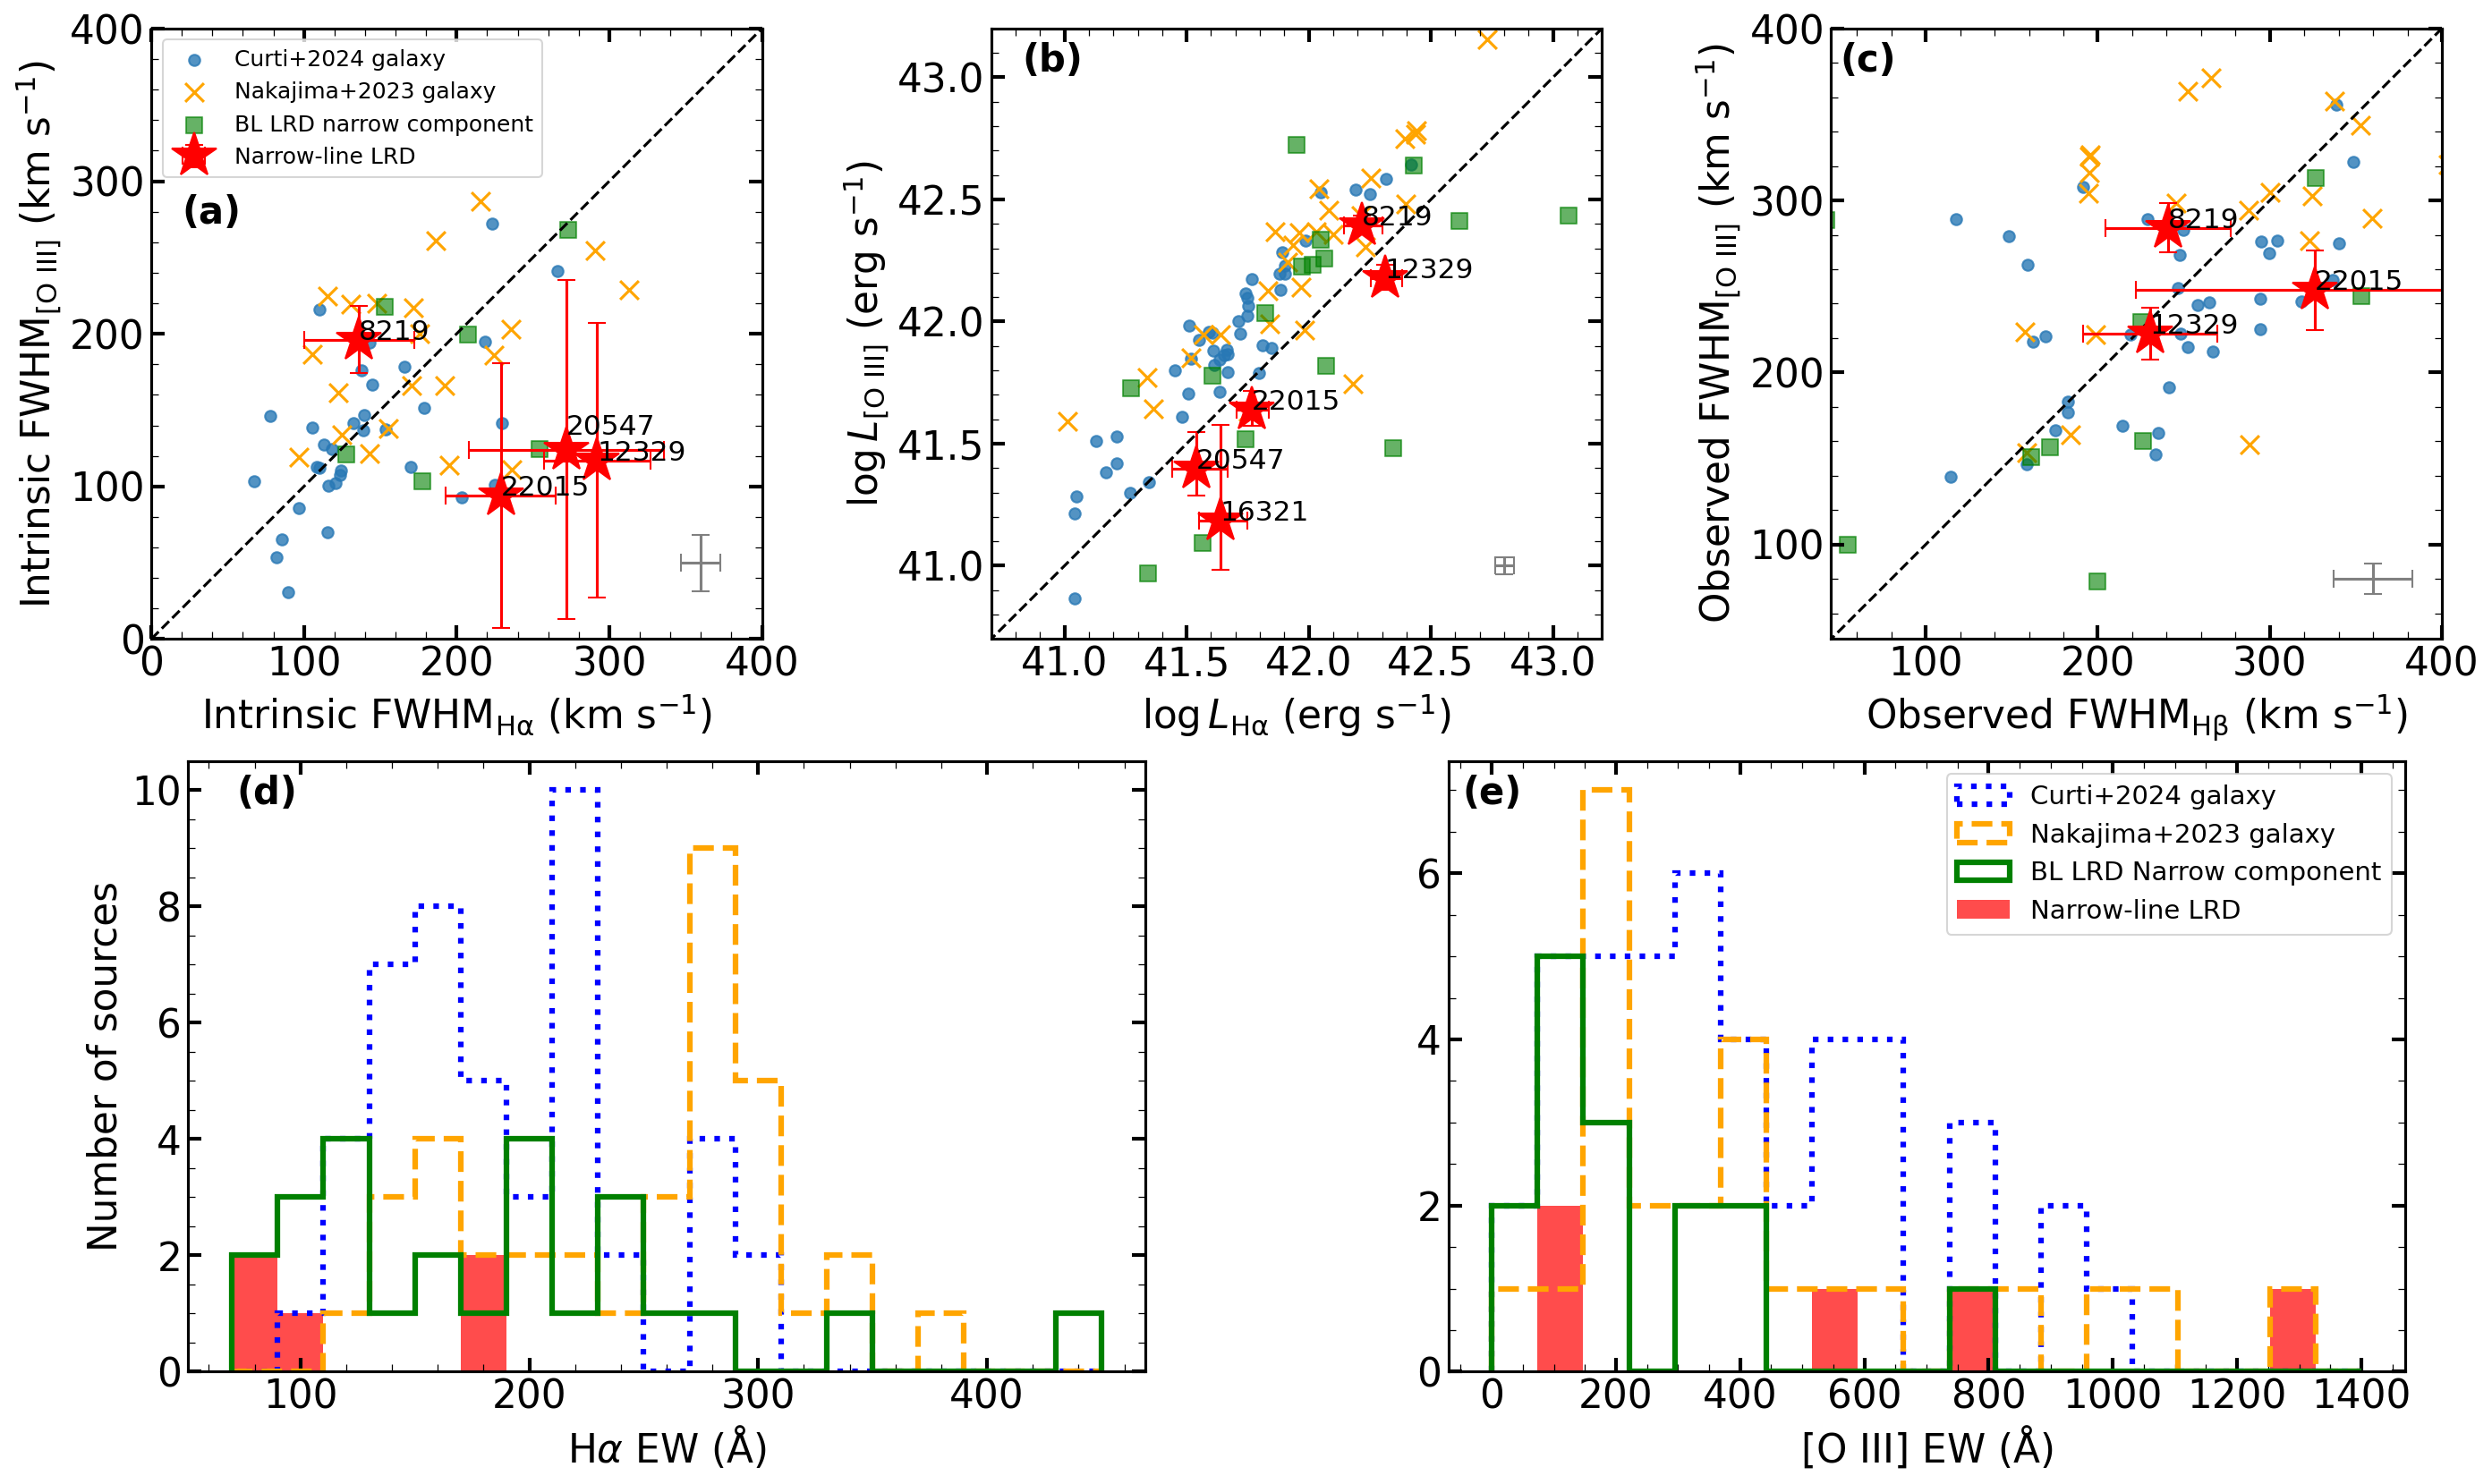

In [ ]:
from matplotlib.ticker import MultipleLocator


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(24, 13), dpi=150)
gs = gridspec.GridSpec(2, 18, figure=fig, height_ratios=[1, 1])  # 2 rows, 6 columns

# 第一行的三个 subplot（均匀分布）
ax2 = fig.add_subplot(gs[0, 0:6])
ax3 = fig.add_subplot(gs[0, 6:12])
ax6 = fig.add_subplot(gs[0, 12:18])

# 第二行的两个 subplot，居中放置（空出左右各一列）
ax4 = fig.add_subplot(gs[1, 1:8])
ax5 = fig.add_subplot(gs[1, 10:17])
# ax6 = fig.add_subplot(gs[1, 0:3])
# 设置纵横比一致
for ax in [ax1, ax2, ax3, ax6]:
    ax.set_aspect('equal')


x = np.linspace(0, 700, 100)

# ax1.plot(x, x, 'k--')
# ax1.scatter(catalog_jadesgal['Ha_FWHM'],catalog_jadesgal['OIII_FWHM'],  c='#2878B5', label='Curti+2024 galaxy', alpha=0.8)
# ax1.scatter(catalog_naka23gal['Ha_FWHM'], catalog_naka23gal['OIII_FWHM'],  c='orange', label='Nakajima+2023 galaxy', marker='x', s = 100)
# ax1.scatter(catalog_lrd['Ha_FWHM_narrow'][~mask], catalog_lrd['OIII_FWHM'][~mask], c='green', label='BL LRD Narrow component', marker='s', s=80, alpha=0.6)
# xerr = catalog_lrd['Ha_FWHM_narrow_err_Ha1'][mask]
# yerr = catalog_lrd['OIII_FWHM_err'][mask]
# ax1.errorbar(catalog_lrd['Ha_FWHM_narrow_Ha1'][mask], catalog_lrd['OIII_FWHM'][mask], 
#             xerr = xerr, yerr = yerr, c='red', label='Narrow-line LRD', markersize= 25, marker='*', linestyle='none', capsize=5)
# # label the name of the narrow-line LRD
# for i in range(len(catalog_lrd['source_id'][mask])):
#     if i == 2:
#         continue
#     elif i== 4:
#         ax1.text(catalog_lrd['Ha_FWHM_narrow_Ha1'][mask].iloc[i] - 55, catalog_lrd['OIII_FWHM'][mask].iloc[i]-15, catalog_lrd['source_id'][mask].iloc[i], fontsize=15)
#     else:
#         ax1.text(catalog_lrd['Ha_FWHM_narrow_Ha1'][mask].iloc[i], catalog_lrd['OIII_FWHM'][mask].iloc[i], catalog_lrd['source_id'][mask].iloc[i], fontsize=15)

# show the median error
# median_err_x = np.nanmedian(catalog_jadesgal['Ha_FWHM_err'])
# median_err_y = np.nanmedian(catalog_jadesgal['OIII_FWHM_err'])
# ax1.errorbar(320, 50, xerr=median_err_x, yerr=median_err_y, fmt='none', ecolor='gray', label='Median error', capsize=5)
# ax1.text(0.05, 0.93, '(a)', fontsize=17, transform=ax1.transAxes, color='black', weight='bold')

# ax1.set_xlim(0, 400)
# ax1.set_ylim(0, 400)
# ax1.set_xlabel(r'Observed $\rm FWHM_{\rm H\alpha}~(\rm km~s^{-1})$')
# ax1.set_ylabel(r'Observed $\rm FWHM_{\rm [O~III]}~(\rm km~s^{-1})$')

median_err_x = np.nanmedian(catalog_jadesgal['Ha_intrinsic_FWHM_err'])
median_err_y = np.nanmedian(catalog_jadesgal['OIII_intrinsic_FWHM_err'])
# median_err_x = np.nanmedian(catalog_lrd['Ha_intrinsic_FWHM_narrow_err'])
# median_err_y = np.nanmedian(catalog_lrd['OIII_intrinsic_FWHM_err'])
ax2.errorbar(360, 50, xerr=median_err_x, yerr=median_err_y, fmt='none', ecolor='gray', capsize=5)
ax2.plot(x, x, 'k--')
ax2.scatter(catalog_jadesgal['Ha_intrinsic_FWHM'],catalog_jadesgal['OIII_intrinsic_FWHM'],  c='#2878B5', label='Curti+2024 galaxy', alpha=0.8)
ax2.scatter(catalog_naka23gal['Ha_intrinsic_FWHM'], catalog_naka23gal['OIII_intrinsic_FWHM'],  c='orange', label='Nakajima+2023 galaxy', marker='x', s = 100)
ax2.scatter(catalog_lrd['Ha_intrinsic_FWHM_narrow'][~mask], catalog_lrd['OIII_intrinsic_FWHM'][~mask], c='green', label='BL LRD narrow component', marker='s', s=80, alpha=0.6)
# x1 = np.array(catalog_lrd['Ha_intrinsic_FWHM_narrow_Ha1'] + catalog_lrd['Ha_intrinsic_FWHM_narrow_err_Ha1'].tolist())
# x2 = np.array(catalog_lrd['Ha_intrinsic_FWHM_narrow_Ha1']).tolist())
# x3 = np.array(catalog_lrd['Ha_intrinsic_FWHM_narrow_Ha1'] - catalog_lrd['Ha_intrinsic_FWHM_narrow_err_Ha1']).tolist())
xerr = [36,35,np.nan,64,36]
yerr = [22,90,np.nan,111,87]
x = [136,292,475,272,229]
y = [196,117,np.nan,124,94]
ax2.errorbar(x, y, xerr = xerr, yerr = yerr, c='red', label='Narrow-line LRD', markersize= 25, marker='*', linestyle='none', capsize=5)
for i in range(len(catalog_lrd['source_id'][mask])):
    if i == 2:
        continue
    elif i == 3:
        ax2.text(x[i], y[i] + 10, catalog_lrd['source_id'][mask].iloc[i], fontsize=15)
    else:
        ax2.text(x[i], y[i], catalog_lrd['source_id'][mask].iloc[i], fontsize=15)
ax2.text(0.05, 0.68, '(a)', fontsize=20, transform=ax2.transAxes, color='black', weight='bold')

ax2.set_xlim(0, 400)
ax2.set_ylim(0, 400)
ax2.set_xlabel(r'Intrinsic $\rm FWHM_{\rm H\alpha}~(\rm km~s^{-1})$')
ax2.set_ylabel(r'Intrinsic $\rm FWHM_{\rm [O~III]}~(\rm km~s^{-1})$')
ax2.legend(loc = 'upper left' , fontsize = 12)


# set major ticks
ax1.yaxis.set_major_locator(MultipleLocator(100))
ax2.yaxis.set_major_locator(MultipleLocator(100))


ax3.scatter(np.log10(catalog_jadesgal['Ha_Luminosity']), np.log10(catalog_jadesgal['OIII_Luminosity']),  c='#2878B5', label='Curti+2024 galaxy', alpha=0.8)
ax3.scatter(np.log10(catalog_naka23gal['Ha_Luminosity']), np.log10(catalog_naka23gal['OIII_Luminosity']),  c='orange', label='Nakajima+2023 galaxy', marker='x', s = 100)
ax3.scatter(np.log10(catalog_lrd['Ha_Luminosity_narrow'][~mask]), np.log10(catalog_lrd['OIII_Luminosity'][~mask]), 
             c='green', label='BL LRD Narrow component', marker='s', s=80, alpha=0.6)

x1 = np.array(np.log10(catalog_lrd['Ha_Luminosity_narrow_Ha1'] + catalog_lrd['Ha_Luminosity_err_narrow_Ha1']).tolist())
x2 = np.array(np.log10(catalog_lrd['Ha_Luminosity_narrow_Ha1']).tolist())
x3 = np.array(np.log10(catalog_lrd['Ha_Luminosity_narrow_Ha1'] - catalog_lrd['Ha_Luminosity_err_narrow_Ha1']).tolist())
xerr = [x1[mask] - x2[mask], x2[mask] - x3[mask]]
y1 = np.array(np.log10(catalog_lrd['OIII_Luminosity'] + catalog_lrd['OIII_Luminosity_err']).tolist())
y2 = np.array(np.log10(catalog_lrd['OIII_Luminosity']).tolist())
y3 = np.array(np.log10(catalog_lrd['OIII_Luminosity'] - catalog_lrd['OIII_Luminosity_err']).tolist())
yerr = [y1[mask] - y2[mask], y2[mask] - y3[mask]]
ax3.errorbar(np.log10(catalog_lrd['Ha_Luminosity_narrow_Ha1'][mask]),np.log10(catalog_lrd['OIII_Luminosity'][mask]), 
             xerr = xerr, yerr = yerr, c='red', label='Narrow-line LRD', markersize= 25, marker='*', linestyle='none', capsize=5)
median_err_x = np.nanmedian(catalog_naka23gal['Ha_Luminosity_err'] / catalog_naka23gal['Ha_Luminosity']) / np.log(10)
median_err_y = np.nanmedian(catalog_naka23gal['OIII_Luminosity_err'] / catalog_naka23gal['OIII_Luminosity']) / np.log(10)
ax3.errorbar(42.8, 41, xerr=median_err_x, yerr=median_err_y, fmt='none', ecolor='gray', capsize=5)
x = np.linspace(40, 44, 100)
ax3.plot(x, x, 'k--')
ax3.set_xlim(40.7, 43.2)
ax3.set_ylim(40.7, 43.2)
ax3.set_xlabel(r'$\log L_{\rm H\alpha}~(\rm erg~s^{-1})$')
ax3.set_ylabel(r'$\log L_{\rm [O~III]}~(\rm erg~s^{-1})$')
ax3.text(0.05, 0.93, '(b)', fontsize=20, transform=ax3.transAxes, color='black', weight='bold')
for i in range(len(catalog_lrd['source_id'][mask])):
    ax3.text(np.log10(catalog_lrd['Ha_Luminosity_narrow_Ha1'][mask].iloc[i]), np.log10(catalog_lrd['OIII_Luminosity'][mask].iloc[i]), catalog_lrd['source_id'][mask].iloc[i], fontsize=15)

# ax3.set_ylim(38, 43)
# ax1.

bins = np.linspace(70, 450, 20)
_ = ax4.hist(catalog_jadesgal['Ha_EW_narrow_Ha1'], bins=bins, histtype='step', color='blue', label='Curti+2024 galaxy', linewidth = 3.,linestyle=':')
_ = ax4.hist(catalog_naka23gal['Ha_EW_narrow_Ha1'], bins=bins, histtype='step', color='orange', label='Nakajima+2023 galaxy', linewidth = 3., linestyle='--')
_ = ax4.hist(catalog_lrd['Ha_EW_narrow_Ha1'][~mask], bins=bins, histtype='step', color='green', label='BL LRD Narrow component', linewidth = 3.)
ax4.hist(catalog_lrd['Ha_EW_narrow_Ha1'][mask], bins=bins, histtype='bar', color='red', label='Narrow-line LRD', linewidth = 2., alpha = 0.7)
# ax4.legend(loc = 1 , fontsize = 13.8)
ax4.set_xlabel(r'H$\alpha$ EW (Å)')
ax4.set_ylabel('Number of sources')
ax4.text(0.05, 0.93, '(d)', fontsize=20, transform=ax4.transAxes, color='black', weight='bold')

bins = np.linspace(0, 1400, 20)
_ = ax5.hist(catalog_jadesgal['OIII_EW'], bins=bins, histtype='step', color='blue', label='Curti+2024 galaxy', linewidth = 3.,linestyle=':')
_ = ax5.hist(catalog_naka23gal['OIII_EW'], bins=bins, histtype='step', color='orange', label='Nakajima+2023 galaxy', linewidth = 3., linestyle='--')
_ = ax5.hist(catalog_lrd['OIII_EW'][~mask], bins=bins, histtype='step', color='green', label='BL LRD Narrow component', linewidth = 3.)
ax5.hist(catalog_lrd['OIII_EW'][mask], bins=bins, histtype='bar', color='red', label='Narrow-line LRD', linewidth = 2., alpha = 0.7)
ax5.legend(loc = 1 , fontsize = 14)
ax5.set_xlabel(r'${\rm [O~III]}$ EW (Å)')
# ax5.set_ylabel('Number of sources')
ax5.text(0.015, 0.93, '(e)', fontsize=20, transform=ax5.transAxes, color='black', weight='bold')

ax6.text(0.015, 0.93, '(c)', fontsize=20, transform=ax6.transAxes, color='black', weight='bold')
x = np.linspace(0, 700, 100)
median_err_x = np.nanmedian(catalog_jadesgal['Hb_FWHM_err'])
median_err_y = np.nanmedian(catalog_jadesgal['OIII_FWHM_err'])
ax6.errorbar(360, 80, xerr=median_err_x, yerr=median_err_y, fmt='none', ecolor='gray', capsize=5)
ax6.plot(x, x, 'k--')
mask_jade = (catalog_jadesgal['Hb_Luminosity']/catalog_jadesgal['Hb_Luminosity_err'] > 1)*(catalog_jadesgal['OIII_Luminosity']/catalog_jadesgal['OIII_Luminosity_err'] > 1)
ax6.scatter(catalog_jadesgal['Hb_FWHM'][mask_jade],catalog_jadesgal['OIII_FWHM'][mask_jade],  c='#2878B5', label='Curti+2024 galaxy', alpha=0.8)
mask_naka = catalog_naka23gal['Hb_Luminosity']/catalog_naka23gal['Hb_Luminosity_err'] > 1
ax6.scatter(catalog_naka23gal['Hb_FWHM'][mask_naka], catalog_naka23gal['OIII_FWHM'][mask_naka],  c='orange', label='Nakajima+2023 galaxy', marker='x', s = 100)
ax6.scatter(catalog_lrd['Hb_FWHM'][~mask], catalog_lrd['OIII_FWHM'][~mask], c='green', label='BL LRD narrow component', marker='s', s=80, alpha=0.6)
# plt.scatter(catalog_lrd['Ha_intrinsic_FWHM_narrow_Ha1'][mask], catalog_lrd['OIII_intrinsic_FWHM'][mask], c='red', label='Narrow-line LRD', s=500, marker='*')
ax6.errorbar(catalog_lrd['Hb_FWHM'][mask], catalog_lrd['OIII_FWHM'][mask], 
            xerr = [36.58, 39.03, 0, 0, 103.71], yerr = catalog_lrd['OIII_FWHM_err'][mask], 
            c='red', label='Narrow-line LRD', markersize= 25, marker='*', linestyle='none', capsize=5)
for i in range(len(catalog_lrd['source_id'][mask])):
    if i == 2 or i == 3:
        continue
    ax6.text(catalog_lrd['Hb_FWHM'][mask].iloc[i], catalog_lrd['OIII_FWHM'][mask].iloc[i], catalog_lrd['source_id'][mask].iloc[i], fontsize=15)
ax6.set_xlabel(r'Observed $\rm FWHM_{\rm H\beta}~(\rm km~s^{-1})$')
ax6.set_ylabel(r'Observed $\rm FWHM_{\rm [O~III]}~(\rm km~s^{-1})$')
ax6.set_xlim(45, 400)
ax6.set_ylim(45, 400)
# plt.tight_layout()
plt.savefig('../Figure/Ha_OIII_FWHM_compare.pdf', dpi=300, bbox_inches='tight')